# Transformer Encoder для классификации AG News

Ноутбук реализует классификатор на основе Transformer Encoder для датасета AG News с использованием PyTorch Lightning.

**Цель**: базовый трансформер-классификатор с encoder-only архитектурой и CLS токеном.

**Датасет**: AG News (train/val 90/10 сплит фиксированным сидом; test отдельно)

**Модель**: Embedding(256) + Positional Encoding → Transformer Encoder (6 слоёв, 8 голов внимания, d_model=256) → CLS токен → Dropout(0.3) → Linear(4)


## Шаг 1: Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Seed set to 42


PyTorch version: 2.5.1+cu121
PyTorch Lightning version: 2.5.2
CUDA available: True


## Шаг 2: Загрузка и разбиение датасета

Используем тот же сплит что и в предыдущих ноутбуках для справедливого сравнения.


In [2]:
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print(f"\nDataset structure:")
print(dataset)
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels
)

print(f"\nAfter split:")
print(f"Train: {len(train_texts)}")
print(f"Val: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(f"\nClasses: {class_names}")


Loading AG News dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Train set size: 120000
Test set size: 7600

After split:
Train: 108000
Val: 12000
Test: 7600

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']


## Шаг 3: Токенизация и словарь

Используем ту же токенизацию и словарь что и в предыдущих ноутбуках. Добавляем специальный токен `<cls>` для классификации.


In [3]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
CLS_TOKEN = '<cls>'
PAD_IDX = 0
UNK_IDX = 1
CLS_IDX = 2

def simple_tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

print("Building vocabulary...")
word_counter = Counter()
for text in train_texts:
    tokens = simple_tokenize(text)
    word_counter.update(tokens)

print(f"Total unique words: {len(word_counter)}")
print(f"Words with freq >= 2: {sum(1 for count in word_counter.values() if count >= 2)}")

vocab = {PAD_TOKEN: PAD_IDX, UNK_TOKEN: UNK_IDX, CLS_TOKEN: CLS_IDX}
vocab_size = 3

max_vocab_size = 30000
for word, count in word_counter.most_common():
    if count >= 2 and vocab_size < max_vocab_size:
        vocab[word] = vocab_size
        vocab_size += 1

print(f"\nVocabulary size: {len(vocab)}")
print(f"Top 10 words: {list(vocab.keys())[:10]}")

idx_to_word = {idx: word for word, idx in vocab.items()}


Building vocabulary...
Total unique words: 62617
Words with freq >= 2: 42450

Vocabulary size: 30000
Top 10 words: ['<pad>', '<unk>', '<cls>', 'the', 'to', 'a', 'of', 'in', 'and', 's']


## Шаг 4: Dataset класс с CLS токеном

Dataset класс добавляет CLS токен в начало каждой последовательности. Паддинг до max в батче будет выполняться в collate_fn.


In [4]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = simple_tokenize(text)
        indices = [CLS_IDX] + [self.vocab.get(token, UNK_IDX) for token in tokens]
        
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(text) for text in texts]
    max_len = max(lengths)
    
    padded_texts = []
    masks = []
    for text in texts:
        pad_length = max_len - len(text)
        padded = torch.cat([text, torch.full((pad_length,), PAD_IDX, dtype=torch.long)])
        mask = torch.cat([torch.ones(len(text), dtype=torch.bool), torch.zeros(pad_length, dtype=torch.bool)])
        padded_texts.append(padded)
        masks.append(mask)
    
    return torch.stack(padded_texts), torch.stack(masks), torch.stack(labels)

max_len = 128
train_dataset = AGNewsDataset(train_texts, train_labels, vocab, max_len=max_len)
val_dataset = AGNewsDataset(val_texts, val_labels, vocab, max_len=max_len)
test_dataset = AGNewsDataset(test_texts, test_labels, vocab, max_len=max_len)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

sample_text, sample_label = train_dataset[0]
print(f"\nSample:")
print(f"  Text length: {len(sample_text)}")
print(f"  First token (should be CLS): {sample_text[0].item()} ({idx_to_word[sample_text[0].item()]})")
print(f"  Label: {sample_label.item()} ({class_names[sample_label.item()]})")


Train dataset size: 108000
Val dataset size: 12000
Test dataset size: 7600

Sample:
  Text length: 54
  First token (should be CLS): 2 (<cls>)
  Label: 1 (Sports)


## Шаг 5: Позиционное кодирование

Реализуем позиционное кодирование для трансформера. Используем синусоидальные функции для кодирования позиций.


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


## Шаг 6: Модель Transformer Encoder

Архитектура:
- Embedding слой: $E \in \mathbb{R}^{|V| \times d}$ где $d=256$, с `padding_idx=0`
- Позиционное кодирование
- Transformer Encoder: 6 слоёв, 8 голов внимания, d_model=256, d_ff=1024
- Используем CLS токен (первый токен) для классификации
- Dropout(0.3) → Linear(256, 4)


In [6]:
class TransformerEncoderClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.3, num_classes=4, max_len=128):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
    
    def forward(self, x, mask):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        src_key_padding_mask = ~mask
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        cls_token = x[:, 0, :]
        x = self.dropout(cls_token)
        x = self.fc(x)
        return x


## Шаг 7: Lightning модуль

PyTorch Lightning модуль с training/validation шагами, логированием train/val loss, val accuracy и val macro F1. Gradient clipping с clip_val=1.0.


In [7]:
class TransformerModule(pl.LightningModule):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.3, num_classes=4, max_len=128, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = TransformerEncoderClassifier(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, num_classes, max_len)
        self.lr = lr
        
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, mask):
        return self.model(x, mask)
    
    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        logits = self(x, mask)
        loss = self.criterion(logits, y)
        
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        logits = self(x, mask)
        loss = self.criterion(logits, y)
        
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-8)
        return optimizer


## Шаг 8: DataLoaders

Создаём DataLoaders с batch_size=128 и collate_fn для динамического паддинга.


In [8]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

sample_batch = next(iter(train_loader))
x, mask, y = sample_batch
print(f"\nSample batch:")
print(f"  Text shape: {x.shape}")
print(f"  Mask shape: {mask.shape}")
print(f"  Labels shape: {y.shape}")


Train batches: 844
Val batches: 94
Test batches: 60

Sample batch:
  Text shape: torch.Size([128, 74])
  Mask shape: torch.Size([128, 74])
  Labels shape: torch.Size([128])


## Шаг 9: Обучение

Обучаем 3 эпохи с Adam оптимизатором (lr=1e-3), gradient_clip_val=1.0, seed=42. Отслеживаем время эпохи.


In [9]:
vocab_size = len(vocab)
model = TransformerModule(
    vocab_size=vocab_size,
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_feedforward=1024,
    dropout=0.3,
    num_classes=4,
    max_len=max_len,
    lr=1e-4
)

trainer = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
    gradient_clip_val=1.0
)

print("Starting training...")
start_time = time.time()
trainer.fit(model, train_loader, val_loader)
total_time = time.time() - start_time

transformer_epoch_time = total_time / 3

print(f"\nTraining completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {transformer_epoch_time:.2f} seconds")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting training...



  | Name      | Type                         | Params | Mode 
-------------------------------------------------------------------
0 | model     | TransformerEncoderClassifier | 12.4 M | train
1 | train_acc | MulticlassAccuracy           | 0      | train
2 | val_acc   | MulticlassAccuracy           | 0      | train
3 | val_f1    | MulticlassF1Score            | 0      | train
4 | criterion | CrossEntropyLoss             | 0      | train
-------------------------------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.678    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.



Training completed in 90.02 seconds
Average time per epoch: 30.01 seconds


## Шаг 10: Оценка на тесте

Оцениваем на test наборе: accuracy и macro F1 score.


In [10]:
from tqdm.notebook import tqdm

test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

model.eval()
device = next(model.parameters()).device
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, mask, y = batch
        x = x.to(device)
        mask = mask.to(device)
        y = y.to(device)
        
        logits = model(x, mask)
        preds = torch.argmax(logits, dim=1)
        
        test_acc(logits, y)
        test_f1(logits, y)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

transformer_test_acc = test_acc.compute().item()
transformer_test_f1 = test_f1.compute().item()

print(f"Test Accuracy: {transformer_test_acc:.4f}")
print(f"Test Macro F1: {transformer_test_f1:.4f}")


  0%|          | 0/60 [00:00<?, ?it/s]

Test Accuracy: 0.9122
Test Macro F1: 0.9120


## Шаг 11: Измерение латентности

Измеряем латентность инференса на 1000 примерах.


In [11]:
model.eval()
device = next(model.parameters()).device
test_subset = torch.utils.data.Subset(test_dataset, range(1000))
test_subset_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

warmup_batches = 10
with torch.no_grad():
    for i, batch in enumerate(test_subset_loader):
        if i < warmup_batches:
            x, mask, _ = batch
            x = x.to(device)
            mask = mask.to(device)
            _ = model(x, mask)
        else:
            break

times = []
with torch.no_grad():
    for batch in test_subset_loader:
        x, mask, _ = batch
        x = x.to(device)
        mask = mask.to(device)
        start = time.time()
        _ = model(x, mask)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        times.append(time.time() - start)

avg_latency = np.mean(times) * 1000
total_time = np.sum(times)
throughput = 1000 / total_time

transformer_latency = avg_latency

print(f"Average latency per batch: {avg_latency:.2f} ms")
print(f"Total time for 1000 examples: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} examples/second")


Average latency per batch: 2178.21 ms
Total time for 1000 examples: 17.4257 seconds
Throughput: 57.39 examples/second


## Шаг 12: Confusion Matrix

Визуализируем confusion matrix на test наборе.


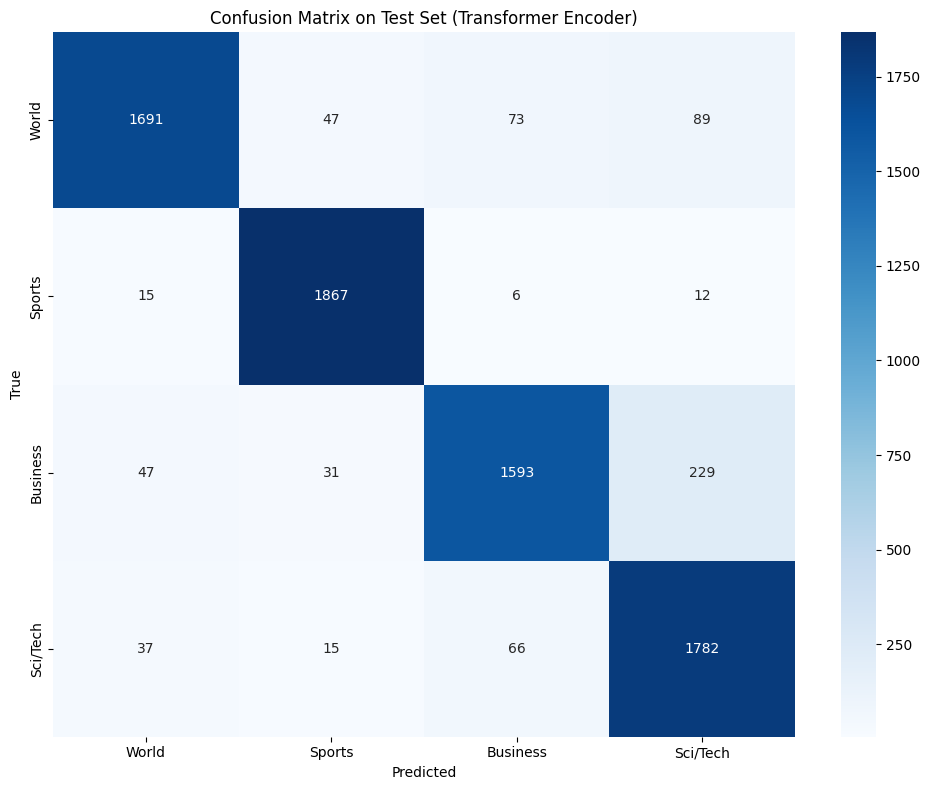

World: Precision=0.945, Recall=0.890, F1=0.917
Sports: Precision=0.953, Recall=0.983, F1=0.967
Business: Precision=0.917, Recall=0.838, F1=0.876
Sci/Tech: Precision=0.844, Recall=0.938, F1=0.888


In [12]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (Transformer Encoder)')
plt.tight_layout()
plt.show()

for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
